In [1]:
import sys
#### CHANGE TO LOCAL PATH LOCATION
sys.path.insert(1,'/home/bwhiteak/ChaosESN/ESN_utils/')

import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema, argrelmax
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec



import traceback
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm


np.random.seed(11)
torch.set_num_threads(4)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:7'

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


### Create signal

In [2]:
FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

muX = np.mean(states[:,0])
signal = states[:,0]-muX  #  Mean centered Lx or x variable signal

In [3]:
M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST

MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
STD = np.std(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal length M={M}')
print(f'Mean of x-variable: {muX:.3f}')
print(f'Normalizing value max-min id {MINMAX:.3f}')
print(f'Normalizing value std id {STD:.3f}')
print(f'Train {TRAINLENGTH} Test {TEST} M {M}')

Signal length M=15000
Mean of x-variable: 0.560
Normalizing value max-min id 38.053
Normalizing value std id 7.912
Train 14000 Test 1000 M 15000


### Helper functions and plotting parameters

In [4]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

import json
from json import JSONEncoder

# numpy arrays cannot be written to json 
# convert to list
class NumpyArrayEncoder(JSONEncoder):
    def default(self,obj):
        if isinstance(obj,np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self,obj)

fontsize = 24
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["text.usetex"] = True 
plt.rcParams["axes.xmargin"] = 0 
plt.rcParams["axes.titlesize"] = fontsize 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["xtick.labelsize"] = fontsize
plt.rcParams["ytick.labelsize"] = fontsize
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams["font.weight"] = "heavy"
plt.rcParams["axes.labelweight"] = "heavy"

### Loading and saving dicts

In [5]:
#with open('Dicts/diagX.json', 'w') as fp:
#    json.dump(dict_diag, fp, cls=NumpyArrayEncoder)
#with open('Dicts/modelsX.json', 'w') as fp:
#    json.dump(dict_models, fp, cls=NumpyArrayEncoder)

fpath = 'Dicts0/diagX.json'
with open(fpath,'r') as j:
    dict_diag = json.loads(j.read())

fpath = 'Dicts0/modelsX.json'
with open(fpath,'r') as j:
    dict_models = json.loads(j.read())
    


### Plot low-error model counts

In [6]:
size = [1000,800,600,400,300,200,100,
        50,40,30,28,26,24,22,20,18,16,14,12,10]

mean_errors = []
num_models = []
    
for i in size:
    try:
        err = np.max(dict_diag[str(i)]['meanError'])
    except:
        err = 0
    if(np.isnan(err)):
        err=0
    mean_errors.append(err)
    
    try:
        num = dict_diag[str(i)]['numModels']
    except:
        num = 0
    if(np.isnan(err)):
        num = 0
    num_models.append(num)

0  (20,)
1  (20,)
2  (20,)
3  (20,)


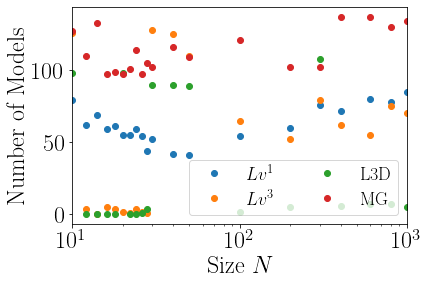

In [7]:
mname = ['num_modelsX_2.npy', 'num_modelsZ.npy', 'num_modelsL3D_2.npy', 'num_modelsMG.npy']
labels = ['$Lv^{1}$','$Lv^{3}$','L3D','MG']
for i in range(len(mname)):
    num_models = np.load(mname[i])
    print(f'{i}  {num_models[::-1].shape}')
    plt.semilogx(size[::-1],num_models[::-1],'o',label=labels[i])
plt.xlabel('Size $N$')
plt.ylabel('Number of Models')
plt.legend(loc='lower right', ncol=2, fontsize=18)
plt.show()

In [ ]:
#np.save('num_modelsX_2',num_models)

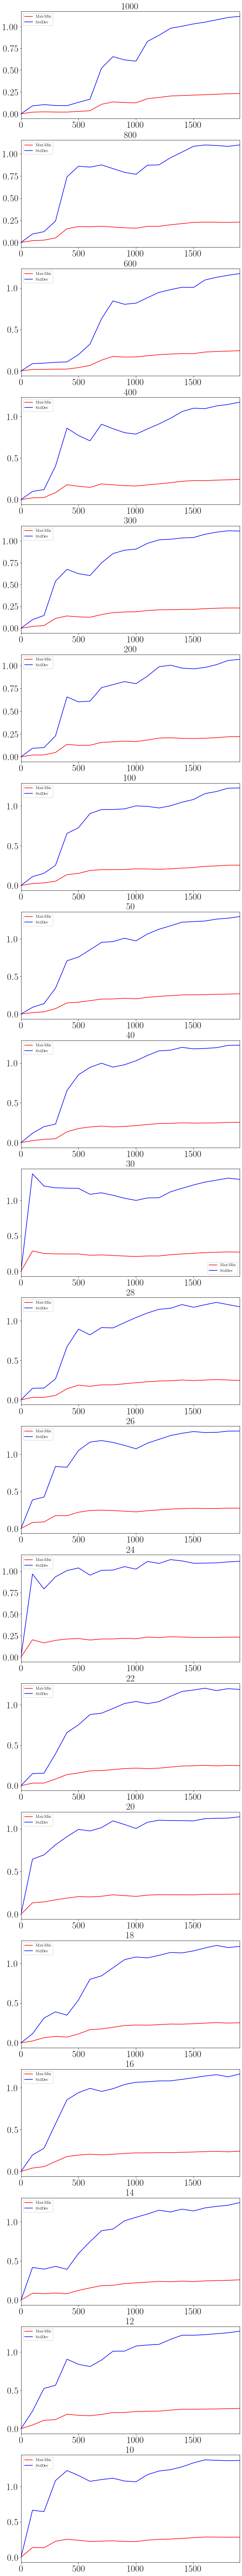

In [47]:
Nplots= len(size)
#axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
segment_errMM = np.zeros((Nplots,20))
segment_errSTD = np.zeros((Nplots,20))
seglengths = np.zeros((1,20))
for n in range(Nplots):
    preds = np.squeeze(np.array(dict_models[str(size[n])]['Preds']))
    for i in range(1,20):
        sigchk = signal[TRAINLENGTH:TRAINLENGTH+i*100]
        predschk = preds[TRAINLENGTH:TRAINLENGTH+i*100]
        errMM = rca.NRMSE(sigchk,
                            predschk,
                            MINMAX)
        errSTD = rca.NRMSE(sigchk,
                             predschk,
                             STD)
        segment_errMM[n,i] = errMM
        segment_errSTD[n,i] = errSTD
        seglengths[0,i] = i*100

fig, axs = plt.subplots(Nplots, figsize=(10,6*Nplots)) 
for n in range(Nplots):
    axs[n].set_title(f'{size[n]}')
    axs[n].plot(seglengths[0,:], segment_errMM[n,:],
             color='r', label=f'Max-Min')
    axs[n].plot(seglengths[0,:], segment_errSTD[n,:],
             color='b', label=f'StdDev')
    axs[n].legend()
plt.show()

### 2D plots of target with prediction

N=1000   Error = 0.13  Error STDDEV = 0.6 KL-div = 0.23 E*kl=0.03
N=800   Error = 0.16  Error STDDEV = 0.77 KL-div = 0.16 E*kl=0.02
N=600   Error = 0.17  Error STDDEV = 0.82 KL-div = 0.88 E*kl=0.15
N=400   Error = 0.16  Error STDDEV = 0.79 KL-div = 0.11 E*kl=0.02
N=300   Error = 0.19  Error STDDEV = 0.9 KL-div = 0.59 E*kl=0.11
N=200   Error = 0.17  Error STDDEV = 0.8 KL-div = 0.32 E*kl=0.05
N=100   Error = 0.21  Error STDDEV = 1.0 KL-div = 0.2 E*kl=0.04
N=50   Error = 0.2  Error STDDEV = 0.97 KL-div = 0.7 E*kl=0.14
N=40   Error = 0.21  Error STDDEV = 1.03 KL-div = 0.75 E*kl=0.16
N=30   Error = 0.21  Error STDDEV = 1.0 KL-div = 5.38 E*kl=1.12
N=28   Error = 0.22  Error STDDEV = 1.04 KL-div = 0.34 E*kl=0.07
N=26   Error = 0.22  Error STDDEV = 1.07 KL-div = 0.91 E*kl=0.2
N=24   Error = 0.21  Error STDDEV = 1.02 KL-div = 1.75 E*kl=0.37
N=22   Error = 0.22  Error STDDEV = 1.04 KL-div = 1.05 E*kl=0.23
N=20   Error = 0.21  Error STDDEV = 1.0 KL-div = 0.89 E*kl=0.19
N=18   Error = 0.22  Error 

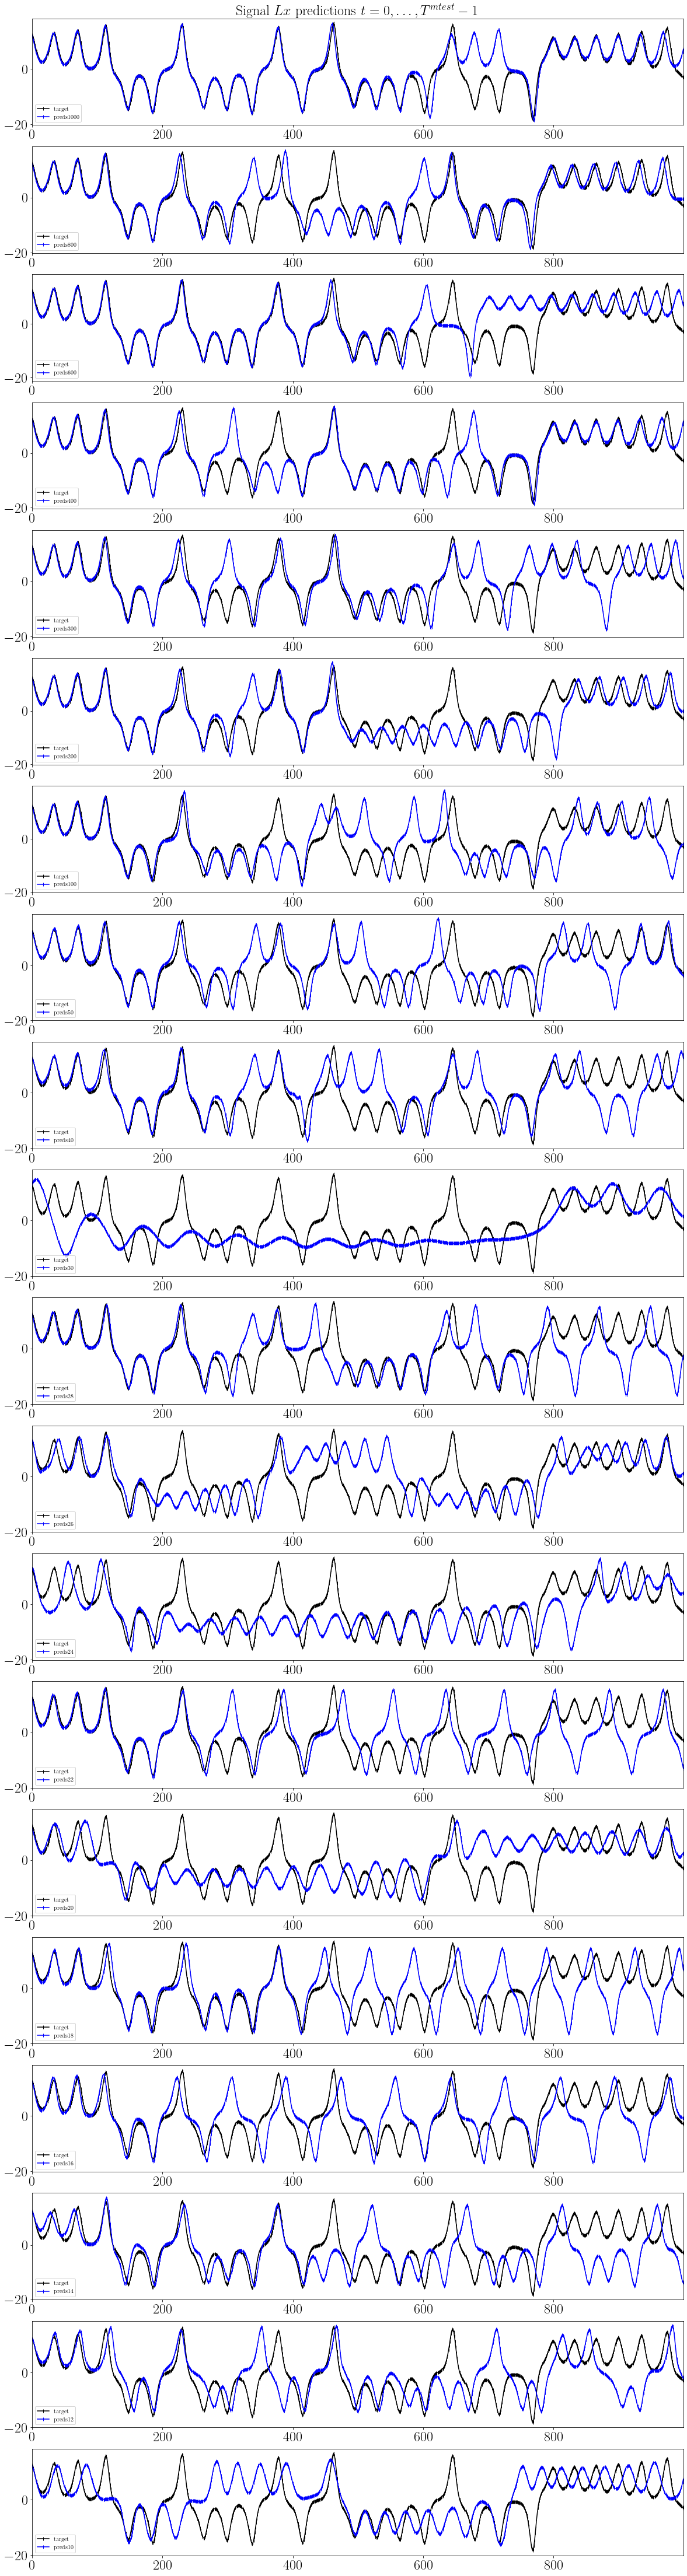

In [48]:
Nplots= len(size)
fig, axs = plt.subplots(Nplots, figsize=(20,4*Nplots)) 
axs[0].set_title('Signal $Lx$ predictions $t=0,\dots,T^{\rm test}-1$')
for n in range(Nplots):
    axs[n].plot(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                marker='|', color='k', label='target')
    preds = dict_models[str(size[n])]['Preds']
    error_testset = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              MINMAX)
    error_std = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                              preds[TRAINLENGTH:TRAINLENGTH + TEST],
                              STD)
    kl,_,_,_ = rca.distribution(signal[TRAINLENGTH:TRAINLENGTH + TEST],
                                preds[TRAINLENGTH:TRAINLENGTH + TEST],
                                 np.min(signal[:TRAINLENGTH+TEST]),
                                 np.max(signal[:TRAINLENGTH+TEST]),
                                 bins=50)
    Ekl = error_testset*kl
    print(f'N={size[n]}   Error = {error_testset.round(2)}  Error STDDEV = {error_std.round(2)} KL-div = {np.round(kl,2)} E*kl={np.round(Ekl,2)}')
    axs[n].plot(preds[TRAINLENGTH:TRAINLENGTH + TEST],
                marker='|', color='b', label=f'preds{size[n]}')
    axs[n].legend()
plt.show()

### Calculate Rank Method-1 for all sizes

In [ ]:
from scipy.optimize import fsolve
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)
all_ranks = []
K = 1
L = 1
tols = [1/10**x for x in range(5,20)]
np.zeros(len(size),)
plt.figure()
for n in size:
    if(dict_diag[str(n)]['numModels']==0):
        all_ranks.append(0)
        continue
    mat = np.array(dict_models[str(n)]['Wnet'])
    Wr, Wi = rca.get_mats(None, K,n, matrix=mat)
    # params [alpha, spectralradius, gamma, ri, rr, loss]
    p = dict_models[str(n)]['Params']
    a,g = p[0], p[2]
    sr = p[1]
    x0 = np.zeros((n,1))
    u0 = np.zeros((K,1))
    A = rca.leaky_jacobian(x0, u0, a, g, Wi, Wr)
    B = rca.partial_u(x0, u0, a, g, Wi, Wr)
    rhoA = np.max(np.abs(rca.eig_spectrum(A)))
    Cn = np.nan_to_num(rca.reachable_matrix(A,B))
    if(K != 3): # Square Cn
        Cn = Cn/np.max(np.abs(rca.eig_spectrum(Cn)))
    else:            # Non-square Cn
        Cn = Cn/np.max(np.abs(np.linalg.svd(Cn, compute_uv=False)))

    rkc = rank_curve(Cn, tols)
    grads = np.gradient(rkc)
    v = np.argmax(grads)
    plt.plot(rkc, label=f'N={n}')
    plt.vlines([v],0,50, color='k')
    if(v+1>=15):
        ave_rank = (rkc[v]+rkc[v-1])//2
    else:
        ave_rank = (rkc[v]+rkc[v+1])//2
    print(f'Targeted reduced rank for N={n} is {ave_rank}\nValue v= {v} Tolerance {tols[v]} Rho A {rhoA.round(2)}')
    print(f'Alpha {np.round(a,2)} --- Rho {np.round(sr,2)}\n')
    all_ranks.append(ave_rank)
plt.ylim(0,50)
plt.show()

### Plot all models error and ranks 

In [ ]:
mean_error = []
for i in size:
    err = dict_diag[str(i)]['meanError']
    mean_error.append(err)
    print(f'N={i}   number {err}')

In [ ]:
rMG = np.load('ranksMG_2.npy')
rL3D = np.load('ranksL3D_2.npy')
rZ = np.load('ranksZ_2.npy')

In [ ]:
mean_errorL3D  = np.load('mean_errorL3D_2.npy')
mean_errorMG  = np.load('mean_errorMG_2.npy')
mean_errorLz  = np.load('mean_errorLz_2.npy')

In [ ]:
mean_errorL3D[mean_errorL3D == 0] = np.nan
mean_errorMG[mean_errorMG == 0] = np.nan
mean_errorLz[mean_errorLz == 0] = np.nan
mean_error[mean_error == 0] = np.nan

In [ ]:
fig, ax = plt.subplots(nrows=2,ncols=1,sharex=True, figsize=(7,10))
fig.subplots_adjust(hspace=0.02)
ax[0].set_title('Ave. Error and Rank vs Size $N$ ')
ax[0].semilogx(size[::-1],mean_error[::-1],'o',linestyle='solid', label='$Lv^{(1)}$')
ax[0].semilogx(size[::-1],mean_errorLz[::-1],'o',linestyle='solid', label='$Lv^{(3)}$')
ax[0].semilogx(size[::-1],mean_errorL3D[::-1],'o',linestyle='solid', label='$L3D$')
ax[0].semilogx(size[::-1],mean_errorMG[::-1],'o',linestyle='solid', label='$MG$')
#ax[0].set_xlabel('Size $N$')
ax[0].set_ylabel('$\overline{\mathcal{E}}$')
ax[0].grid(True, which="both", ls="-")
ax[0].legend(loc='lower right')

ax[1].loglog(size[::-1],all_ranks[::-1],'d', label='$Lv^{(1)}$')
ax[1].loglog(size[::-1],rZ[::-1],'d', label='$Lv^{(2)}$')
ax[1].loglog(size[::-1],rL3D[::-1],'d', label='$L3D$')
ax[1].loglog(size[::-1],rMG[::-1],'d', label='$MG$')
ax[1].loglog(size[::-1],size[::-1],color='k', label='N')
ax[1].set_xlabel('Size $N$')
ax[1].set_ylabel('$\mathrm{rank}(C_N)$')
plt.grid(True, which="both", ls="-")
ax[1].legend()
plt.show()
#fig.savefig("../PlotNBs/NBoutputs/mm_rank_and_error.png", format='png', 
#            dpi=300, bbox_inches='tight', pad_inches=.01)

### Get time-step of divergence 

In [ ]:
def Rxy(x,y):
    return np.dot(x.T,y)/(np.linalg.norm(x)*np.linalg.norm(y))
FREE =1000
T = M + FREE
Nsizes = len(size)
correlations = np.zeros((Nsizes,T))
thresholds = np.zeros(Nsizes)
threshold_location = np.zeros(Nsizes, dtype=int)
for i in range(Nsizes): 
    k = size[i]
    corr_length = T-k # calculate for j= 0,..., M-k
    pred = np.array(dict_models[str(k)]['Preds']) # Get size N predictions
    
    for j in range(corr_length):
        tar = signal[j:j+k].reshape((k,1))
        prd = pred[j:j+k].reshape((k,1))
        correlations[i,j] = Rxy(tar,prd)

    minVal = correlations[i,TRAINLENGTH-1000:TRAINLENGTH].min()
    thresholds[i] = minVal*.95
    threshold_location[i] = np.where(correlations[i,TRAINLENGTH:]<thresholds[i])[0][0]
    print(f'k=N={k} Trainingset min={minVal.round(3)}  threshold={thresholds[i]:.3f}',
          f' Location={threshold_location[i]}')


### Plot divergence

In [ ]:
LEAD = 100
mx = np.max(np.abs(signal))
fig, axs = plt.subplots(Nplots, figsize=(15,8*Nplots)) 
for n in range(Nsizes):
    pred = dict_models[str(size[n])]['Preds']
    axs[n].plot(signal[TRAINLENGTH-LEAD:TRAINLENGTH+TEST]/mx, color='k', label='target')
    axs[n].plot(pred[TRAINLENGTH-LEAD:TRAINLENGTH+TEST]/mx,color='b', label='pred')
    axs[n].plot(correlations[n,TRAINLENGTH-LEAD:TRAINLENGTH+TEST], color='r', label=f'k={size[n]}')
    axs[n].axvline(LEAD+threshold_location[n],color='r', linestyle='dashed', label=f't={threshold_location[n]}')
    axs[n].axvline(LEAD,color='k')
    axs[n].axhline(thresholds[n],color='r', linestyle='dotted')
    axs[n].set_ylabel('$\mathbf{R}_{xy}[k]\enspace ,\enspace Lx$')
    axs[n].set_xlabel('Time-steps $t$')
    axs[n].legend(fontsize=24,loc='lower right')
axs[0].set_title('Correlation (solid red) at $t$-step (dashed red), $\mathbf{R}_{xy}[k]<\mathrm{threshold}$ (dotted red) ')
plt.show()

### Chaos plot

In [ ]:
from scipy.signal import argrelmax
import pandas as pd
import seaborn as sns

In [ ]:
def rank_along_trajectory(wr, wi, a, g, forcing, n, k, tolerance):
    T = forcing.shape[0]
    ranks = np.zeros(T)
    radii = np.zeros(T)
    def Func(x):
        return np.squeeze(-x.reshape(n,1) + (1-a)*x.reshape(n,1) +\
                          a*g*np.tanh(np.dot(wr,x.reshape(n,1)) +\
                         (np.dot(wi,ueq.reshape(k,1)).reshape(n,1))))
    for i in range(T):
        ueq = forcing[i]
        x0 = np.ones((n,1))*.5
        xeq = (fsolve(Func,x0)).reshape(n,1)
        A = rca.leaky_jacobian(xeq, ueq.reshape(k,1), a, g, wi, wr)
        radii[i] = np.max(np.abs(rca.eig_spectrum(A)))
        B = rca.partial_u(xeq, ueq.reshape(k,1), a, g, wi, wr)
        Cplus = rca.gpu_reachable_matrix(A, B)
        ranks[i] = rca.rank(Cplus, tolerance)
    return ranks, radii

In [ ]:
N = 28
K = 1
v = 0
pred = np.array(dict_models[str(N)]['Preds'])
start, end= 13900,15000
p = dict_models[str(N)]['Params']
mat = np.array(dict_models[str(N)]['Wnet'])
Wr, Wi = rca.get_mats(None, K,N, matrix=mat)
sig_rks, radii = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            signal[start:end], N, K, tols[v])
pred_rks,_ = rank_along_trajectory( Wr, Wi, p[0], p[2],
                            pred[start:end],N, K, tols[v])

top,bottom  = 13900,15000
mu = .56018255




gs = gridspec.GridSpec(2, 1)
fig = plt.figure(figsize=(10,14))
ax1 = plt.subplot(gs[0])
fontsize = 28


data_dict = {'y': signal[14000:],
             'yh30': np.squeeze(pred[14000:]),
            }
alpha = .5
bins = 50
df = pd.DataFrame(data=data_dict)
sns.distplot(df['y'],
             label='$Lv^{(1)}$',
             bins=bins,
             color='k',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=.5),
             ax=ax1)
sns.distplot(df['yh30'],
             label='$\widehat{\mathbf{y}},\,N=20$',
             bins=bins,
             color='b',
             axlabel=False,
             norm_hist=True,
             hist_kws=dict(alpha=alpha),
             ax=ax1)
ax1.legend(handlelength=.5,loc='upper left', fontsize=fontsize-4)
ax1.set_ylabel(r'${P}(v^{(1)}_t)$', fontsize=fontsize,  color='black', weight='heavy', labelpad=10)
ax1.set_xlabel(r'Range of $v^{(1)}_t$', fontsize=fontsize,  color='black', weight='heavy')
ax1.text(-0.2, 1.,s='$(\mathbf{a})$', transform=ax1.transAxes, 
            size=30, weight='bold')



start, end= 13900,14500
xax = np.array([k for k in range(start,end)],dtype=int)
plt.rcParams['xtick.major.pad']='8'
gs1 = gs[1].subgridspec(2,1, hspace=.02)

ax2 = plt.subplot(gs1[0])
ax2.plot(xax,signal[start:end],'k', label=r'$Lv^{(1)}$')
ax2.plot(xax,pred[start:end],'b-', label='$\widehat{\mathbf{y}},\,N=20$', alpha = .8)
ax2.set_ylim(-20,27)
ax2.legend(loc='upper right',
           framealpha=1,
           handlelength=.5,
           ncol=2,
           fontsize=24,
           borderpad=.2,
           borderaxespad=.2)

ax2.set_ylabel(r'$v^{(1)}_t-\mu_{v^{(1)}}$', fontsize=fontsize,  color='black', weight='heavy')
ax2.text(-0.2, 1.,s='$(\mathbf{b})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax2.set_xticks([])


ax3 = plt.subplot(gs1[1])
ax3.text(-0.2, 0,s='$(\mathbf{c})$', transform=ax2.transAxes, 
            size=30, weight='bold')
ax3.plot(xax,sig_rks[:-500],
        color='k', label='$Lv^{(1)}$', alpha=1.)
ax3.plot(xax,pred_rks[:-500],
        color= 'b', label='$\widehat{\mathbf{y}}$', alpha=.6)
lowlim, uplim = 0,30
ax3.set_ylim(lowlim, uplim)
ax3.set_ylabel('$\mathrm{rank}(\mathbf{\mathcal{C}}_{28};10^{-16})$', labelpad=22)
ax3.set_xlabel('Time-step $t$')
ax3.set_xticks([13900,14000,14250,14500])
ax3.set_xticklabels([-100,0,250,500])
ax3.set_yticks([24,28])
ax3.set_yticklabels([24,28])

ax2.axvline(14000, c='k',ls='dashed' )
ax2.axvline(14265, c='r',ls='dashed' )
ax2.vlines(np.where(radii[:-500]>1.13)[0] + 13900, -25,27, color='k', linewidths=1, alpha=.12)
ax3.vlines(np.where(radii[:-500]>1.13)[0] + 13900, lowlim,uplim, color='k', linewidths=1, alpha=.12)
ax3.axvline(14000, c='k',ls='dashed' )
ax3.axvline(14265, c='r',ls='dashed' )
plt.tight_layout()
plt.show()
#fig.savefig("../PlotNBs/NBoutputs/Lx_lines_combined.pdf", format='pdf', bbox_inches='tight', pad_inches=.01)